In [46]:
import pandas as pd
import os
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import gc
import pickle
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
## Function to reduce the memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
# read data from file:
train_set0 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/train_set0.csv')
train_set0 = reduce_mem_usage(train_set0)
train_set1 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/train_set1.csv')
train_set1 = reduce_mem_usage(train_set1)
train_set2 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/train_set2.csv')
train_set2 = reduce_mem_usage(train_set2)
train_set3 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/train_set3.csv')
train_set3 = reduce_mem_usage(train_set3)

Mem. usage decreased from 1603.49 Mb to 467.68 Mb (70.8% reduction)
Mem. usage decreased from 571.30 Mb to 166.63 Mb (70.8% reduction)
Mem. usage decreased from 368.96 Mb to 107.61 Mb (70.8% reduction)
Mem. usage decreased from 173.23 Mb to 50.53 Mb (70.8% reduction)


In [6]:
train_set0.shape, train_set1.shape, train_set2.shape, train_set3.shape

((11676263, 18), (4160090, 18), (2686678, 18), (1261421, 18))

In [7]:
train_set0.head()

,site_id,building_id,primary_use,square_feet,timestamp,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,month,weekday,hour,meter_reading
0,0,0,0,0.008171,2016-05-20 18:00:00,0.698242,0.606934,0.863770,0.425537,0.0,0.0,0.0,0.0,0.120483,5.0,4.0,18.0,68.219910
1,0,0,0,0.008171,2016-05-20 19:00:00,0.706055,0.597168,0.873535,0.235596,0.0,0.0,0.0,0.0,0.120483,5.0,4.0,19.0,81.423767
2,0,0,0,0.008171,2016-05-20 20:00:00,0.740723,0.595703,0.881836,0.148804,0.0,0.0,0.0,0.0,0.158325,5.0,4.0,20.0,70.020416
3,0,0,0,0.008171,2016-05-20 21:00:00,0.763184,0.589844,0.873535,0.210693,1.0,0.0,0.0,0.0,0.196167,5.0,4.0,21.0,70.620689
4,0,0,0,0.008171,2016-05-20 22:00:00,0.734375,0.584961,0.891602,0.235596,1.0,0.0,0.0,0.0,0.139404,5.0,4.0,22.0,74.021523


### data preparation

In [8]:
# need to rescale the meter_reading:
rob_0 = RobustScaler()
mm_0 = MinMaxScaler()
rob_1 = RobustScaler()
mm_1 = MinMaxScaler()
rob_2 = RobustScaler()
mm_2 = MinMaxScaler()
rob_3 = RobustScaler()
mm_3 = MinMaxScaler()

data scaling for y: log1p --> RobustScaler --> MinMaxScaler

In [9]:
train_set0.meter_reading = mm_0.fit_transform(rob_0.fit_transform(np.log1p(train_set0.meter_reading).values.reshape(-1,1)))
train_set1.meter_reading = mm_1.fit_transform(rob_1.fit_transform(np.log1p(train_set1.meter_reading).values.reshape(-1,1)))
train_set2.meter_reading = mm_2.fit_transform(rob_2.fit_transform(np.log1p(train_set2.meter_reading).values.reshape(-1,1)))
train_set3.meter_reading = mm_3.fit_transform(rob_3.fit_transform(np.log1p(train_set3.meter_reading).values.reshape(-1,1)))

In [10]:
pickle.dump(mm_0, open('mm_0.pkl', 'wb'))
pickle.dump(rob_0, open('rob_0.pkl', 'wb'))
pickle.dump(mm_1, open('mm_1.pkl', 'wb'))
pickle.dump(rob_1, open('rob_1.pkl', 'wb'))
pickle.dump(mm_2, open('mm_2.pkl', 'wb'))
pickle.dump(rob_2, open('rob_2.pkl', 'wb'))
pickle.dump(mm_3, open('mm_3.pkl', 'wb'))
pickle.dump(rob_3, open('rob_3.pkl', 'wb'))

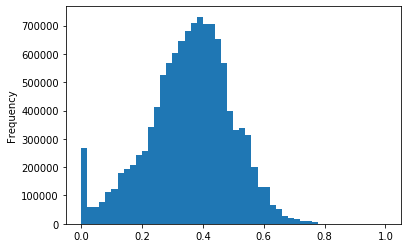

In [11]:
train_set0.meter_reading.plot.hist(bins=50)

In [12]:
train_set0.head()

,site_id,building_id,primary_use,square_feet,timestamp,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,month,weekday,hour,meter_reading
0,0,0,0,0.008171,2016-05-20 18:00:00,0.698242,0.606934,0.863770,0.425537,0.0,0.0,0.0,0.0,0.120483,5.0,4.0,18.0,0.375416
1,0,0,0,0.008171,2016-05-20 19:00:00,0.706055,0.597168,0.873535,0.235596,0.0,0.0,0.0,0.0,0.120483,5.0,4.0,19.0,0.390884
2,0,0,0,0.008171,2016-05-20 20:00:00,0.740723,0.595703,0.881836,0.148804,0.0,0.0,0.0,0.0,0.158325,5.0,4.0,20.0,0.377692
3,0,0,0,0.008171,2016-05-20 21:00:00,0.763184,0.589844,0.873535,0.210693,1.0,0.0,0.0,0.0,0.196167,5.0,4.0,21.0,0.378437
4,0,0,0,0.008171,2016-05-20 22:00:00,0.734375,0.584961,0.891602,0.235596,1.0,0.0,0.0,0.0,0.139404,5.0,4.0,22.0,0.382547


In [15]:
train_set0.building_id.nunique(), train_set1.building_id.nunique(), train_set2.building_id.nunique(), train_set3.building_id.nunique()

(1413, 498, 324, 145)

### network design:
1. Each has 6 inputs, 5 of them are inputs of embedding layers, the rest is numeric input.
2. Categorical embedding for features: building_id, month, hour, etc .
3. Output of them are concatenated as input of main network.

## network structure and parameters optimization
based on the design of the network, I will search for 
1. best number of layers, 
2. activation, 
3. learning rate, 
4. number of neurons

### prepare data for search
due to the hardware limitation of laptop, I will use a small size of data from training data in my search to improve search efficiency.

In [25]:
# get 1/10 data from test_set0 as search_set
split_forSearch = StratifiedShuffleSplit(n_splits=1, test_size = 0.1, random_state=100)
for train_index, test_index in split_forSearch.split(train_set0, train_set0.building_id):
    strat_search_set = train_set0.iloc[test_index]
# split search_set:
split_Search = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=100)
for train_index, test_index in split_Search.split(strat_search_set, strat_search_set.building_id):
    search_train_set = strat_search_set.iloc[train_index]
    search_test_set = strat_search_set.iloc[test_index]

In [26]:
train_set0.shape, search_train_set.shape, search_test_set.shape

((11676263, 18), (934101, 18), (233526, 18))

In [27]:
X_srch = [search_train_set.building_id.values, search_train_set.primary_use.values, 
      search_train_set.month.values, search_train_set.weekday.values, search_train_set.hour.values, 
      search_train_set.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y_srch = search_train_set.meter_reading.values
X_test_srch = [search_test_set.building_id.values, search_test_set.primary_use.values, 
      search_test_set.month.values, search_test_set.weekday.values, search_test_set.hour.values, 
      search_test_set.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y_test_srch = search_test_set.meter_reading.values

In [28]:
X_srch

[array([1139, 1186,  331, ..., 1356, 1393,  637], dtype=int16),
 array([6, 4, 0, ..., 0, 1, 0], dtype=int8),
 array([5., 9., 6., ..., 8., 4., 9.], dtype=float16),
 array([5., 4., 3., ..., 5., 5., 4.], dtype=float16),
 array([14.,  4., 23., ...,  7.,  9., 10.], dtype=float16),
 array([[6.000e+00, 3.845e-01, 5.972e-01, ..., 5.000e+00, 5.000e+00,
         1.400e+01],
        [4.000e+00, 1.792e-01, 6.050e-01, ..., 9.000e+00, 4.000e+00,
         4.000e+00],
        [0.000e+00, 3.298e-01, 7.202e-01, ..., 6.000e+00, 3.000e+00,
         2.300e+01],
        ...,
        [0.000e+00, 1.040e-01, 5.830e-01, ..., 8.000e+00, 5.000e+00,
         7.000e+00],
        [1.000e+00, 1.733e-01, 4.468e-01, ..., 4.000e+00, 5.000e+00,
         9.000e+00],
        [0.000e+00, 4.467e-03, 5.767e-01, ..., 9.000e+00, 4.000e+00,
         1.000e+01]], dtype=float16)]

### optimization for number of layers for main layers

In [41]:
num_layers = 1 
while num_layers < 6: 
    embeddings = []
    
    input_building_id = layers.Input(shape=(1,), name='input_building_id')
    building_id_emb = layers.Embedding(1449, 50, name = 'building_id_emb')(input_building_id)
    building_id_emb = layers.Flatten()(building_id_emb)
    building_id_emb = layers.Dropout(0.2)(building_id_emb)
    building_id_emb = layers.Dense(20, activation='relu')(building_id_emb)
    building_id_emb = layers.BatchNormalization()(building_id_emb)
#    building_id_emb = layers.Dropout(0.1)(building_id_emb)
    building_id_emb = layers.Dense(10, activation='relu')(building_id_emb)
    building_id_emb = layers.BatchNormalization()(building_id_emb)
    embeddings.append(building_id_emb)
    
    input_primary_use = layers.Input(shape=(1,), name='input_primary_use')
    primary_use_emb = layers.Embedding(16, 8, name = 'primary_use_emb')(input_primary_use)
    primary_use_emb = layers.Flatten()(primary_use_emb)
#    primary_use_emb = layers.Dropout(0.1)(primary_use_emb)
    primary_use_emb = layers.Dense(4, activation='relu')(primary_use_emb)
    primary_use_emb = layers.BatchNormalization()(primary_use_emb)
    embeddings.append(primary_use_emb)
    
    input_month = layers.Input(shape=(1,), name='input_month')
    month_emb = layers.Embedding(12, 4, name = 'month_emb')(input_month)
    month_emb = layers.Flatten()(month_emb)
#    month_emb = layers.Dropout(0.1)(month_emb)
    month_emb = layers.Dense(2, activation='relu')(month_emb)
    month_emb = layers.BatchNormalization()(month_emb)
    embeddings.append(month_emb)
    
    input_weekday = layers.Input(shape=(1,), name='input_weekday')
    weekday_emb = layers.Embedding(7, 3, name = 'month_emb')(input_weekday)
    weekday_emb = layers.Flatten()(weekday_emb)
    weekday_emb = layers.Dense(2, activation='relu')(weekday_emb)
    weekday_emb = layers.BatchNormalization()(weekday_emb)
    embeddings.append(month_emb)
    
    input_hour = layers.Input(shape=(1,), name='input_hour')
    hour_emb = layers.Embedding(24, 8, name = 'hour_emb')(input_hour)
    hour_emb = layers.Flatten()(hour_emb)
    hour_emb = layers.Dense(3, activation='relu')(hour_emb)
    hour_emb = layers.BatchNormalization()(hour_emb)
    embeddings.append(hour_emb)

    input_numeric = layers.Input(shape=(13,), name = 'input_numeric')
    embeddings.append(input_numeric)
    
    main_Layers = layers.Concatenate()(embeddings)
    
    current_layer = 0 
    while current_layer < num_layers: 
        main_Layers = layers.Dense(50, activation='relu')(main_Layers)
        main_Layers = layers.BatchNormalization()(main_Layers)
        current_layer+=1 
    
    main_Layers = layers.Dense(20, activation='relu')(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
#    main_Layers = layers.Dropout(0.05)(main_Layers)
    main_Layers = layers.Dense(5, activation='relu')(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
#    main_Layers = layers.Dropout(0.05)(main_Layers)
    output = layers.Dense(1)(main_Layers)

    model = tf.keras.Model([input_building_id, input_primary_use, input_month,
                            input_weekday, input_hour, input_numeric], output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001,beta_1=0.9,beta_2=0.999, epsilon=1e-08), 
                  loss='mse' # tf.keras.losses.mean_squared_error
                  , metrics=['mae']
                 )
    history = model.fit(X_srch, y_srch, epochs=50
              , batch_size=64
              , verbose=0
             )
    
    test_pred = model.predict(X_test_srch)
    test_rmse = np.sqrt(mean_squared_error(y_test_srch, test_pred))
    print('num_main_layers:',(num_layers+2),'\ntest_rmse_score:',
          test_rmse,'\ntrainingMSE:',history.history.get('loss'),'\n') 
    num_layers +=1

num_main_layers: 3 
test_rmse_score: 0.043319277 
trainingMSE: [0.009893378128833202, 0.003332816328923974, 0.002989253591142015, 0.00283732685851579, 0.0027037841369748883, 0.002624461611547396, 0.002568561064604196, 0.002514130400351005, 0.002485008112157326, 0.002452244454645007, 0.002424419814514013, 0.002404790903181214, 0.002382205432957424, 0.002349218228289913, 0.002324607425408289, 0.0022993327014002233, 0.002291416039088134, 0.002287998658085317, 0.0022748965132983116, 0.0022554433438659234, 0.002234434313463771, 0.0022457728041247334, 0.002227759183223973, 0.002217059113715693, 0.002223296324815341, 0.0022128714751745793, 0.0022023780870037302, 0.002193375331780781, 0.0021869337748193756, 0.0021814615308745748, 0.0021834739594804036, 0.0021786169431410496, 0.002170805390094027, 0.0021552052700971676, 0.002168113967587974, 0.0021612184957790965, 0.0021675024719335165, 0.002153787755699229, 0.002146614511092832, 0.002142324804787594, 0.0021385091385012346, 0.002139756439993299

I will use 6 main layers for this network

### activation optimization

In [88]:
actvs = ['relu','tanh','sigmoid']
for each in actvs:
    actv = each
    alpha = 0.001
    
    embeddings = []
    
    input_building_id = layers.Input(shape=(1,), name='input_building_id')
    building_id_emb = layers.Embedding(1449, 50, name = 'building_id_emb')(input_building_id)
    building_id_emb = layers.Flatten()(building_id_emb)
    building_id_emb = layers.Dropout(0.2)(building_id_emb)
    building_id_emb = layers.Dense(20, activation=actv)(building_id_emb)
    building_id_emb = layers.BatchNormalization()(building_id_emb)
#    building_id_emb = layers.Dropout(0.1)(building_id_emb)
    building_id_emb = layers.Dense(10, activation=actv)(building_id_emb)
    building_id_emb = layers.BatchNormalization()(building_id_emb)
    embeddings.append(building_id_emb)
    
    input_primary_use = layers.Input(shape=(1,), name='input_primary_use')
    primary_use_emb = layers.Embedding(16, 8, name = 'primary_use_emb')(input_primary_use)
    primary_use_emb = layers.Flatten()(primary_use_emb)
#    primary_use_emb = layers.Dropout(0.1)(primary_use_emb)
    primary_use_emb = layers.Dense(4, activation=actv)(primary_use_emb)
    primary_use_emb = layers.BatchNormalization()(primary_use_emb)
    embeddings.append(primary_use_emb)
    
    input_month = layers.Input(shape=(1,), name='input_month')
    month_emb = layers.Embedding(12, 4, name = 'month_emb')(input_month)
    month_emb = layers.Flatten()(month_emb)
#    month_emb = layers.Dropout(0.1)(month_emb)
    month_emb = layers.Dense(2, activation=actv)(month_emb)
    month_emb = layers.BatchNormalization()(month_emb)
    embeddings.append(month_emb)
    
    input_weekday = layers.Input(shape=(1,), name='input_weekday')
    weekday_emb = layers.Embedding(7, 3, name = 'month_emb')(input_weekday)
    weekday_emb = layers.Flatten()(weekday_emb)
    weekday_emb = layers.Dense(2, activation=actv)(weekday_emb)
    weekday_emb = layers.BatchNormalization()(weekday_emb)
    embeddings.append(month_emb)
    
    input_hour = layers.Input(shape=(1,), name='input_hour')
    hour_emb = layers.Embedding(24, 8, name = 'hour_emb')(input_hour)
    hour_emb = layers.Flatten()(hour_emb)
    hour_emb = layers.Dense(3, activation=actv)(hour_emb)
    hour_emb = layers.BatchNormalization()(hour_emb)
    embeddings.append(hour_emb)

    input_numeric = layers.Input(shape=(13,), name = 'input_numeric')
    embeddings.append(input_numeric)
    
    main_Layers = layers.Concatenate()(embeddings)
    
    main_Layers = layers.Dense(50, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dense(50, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dense(50, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dense(50, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dense(20, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
#    main_Layers = layers.Dropout(0.05)(main_Layers)
    main_Layers = layers.Dense(5, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
#    main_Layers = layers.Dropout(0.05)(main_Layers)
    output = layers.Dense(1)(main_Layers)

    model = tf.keras.Model([input_building_id, input_primary_use, input_month,
                            input_weekday, input_hour, input_numeric], output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = alpha,beta_1=0.9,beta_2=0.999, epsilon=1e-08)
                  , loss='mse'
                  , metrics=['mae']
                 )
    history = model.fit(X_srch, y_srch, epochs=30
              , batch_size=64
              , verbose=0
             )
    
    test_pred = model.predict(X_test_srch)
    test_rmse = np.sqrt(mean_squared_error(y_test_srch, test_pred))
    print('activation:',actv, '\ntest_rmse_score:',
          test_rmse,'\ntrainingMSE:',history.history.get('loss'),'\n') 
    

activation: relu 
test_rmse_score: 0.102770016 
trainingMSE: [0.011147059708640147, 0.003358485337275134, 0.0029429113236418233, 0.0027257701204925367, 0.0025971752100637084, 0.0025003659997509093, 0.0024499420514320826, 0.0024051647928598208, 0.002371382188151805, 0.0023385558232208773, 0.0022967880933195007, 0.002282444670275494, 0.0022615779794734705, 0.0022305388789500102, 0.002220034948816495, 0.0022084448189192704, 0.002188725276605423, 0.002181484669291406, 0.0021570510842488827, 0.0021536383847215157, 0.0021413787215563656, 0.0021400112482792993, 0.0021190900188549763, 0.002118499205061958, 0.0020997507699717865, 0.002098732975151943, 0.002095273259730199, 0.002083405537493529, 0.002067567318217372, 0.002073322985799353] 

activation: tanh 
test_rmse_score: 0.044920884 
trainingMSE: [0.006845265448053675, 0.003210480836428016, 0.0030601517432889097, 0.003007285532997659, 0.0029233139257168364, 0.0028318823897634368, 0.002844542812161567, 0.002807555529748033, 0.0027351567092679

Sigmoid activation has better performance

### learning rate optimization

In [90]:
count = 0
while count < 15:
    actv = 'sigmoid'
    rande = -1.5 * np.random.rand() - 2.5  # range from -2.5 to -4. To shrink down the range: -0.5 * np.random.rand() - 3
    alpha = 10**rande  # range from 0.0001 to 0.00316
    
    embeddings = []
    
    input_building_id = layers.Input(shape=(1,), name='input_building_id')
    building_id_emb = layers.Embedding(1449, 50, name = 'building_id_emb')(input_building_id)
    building_id_emb = layers.Flatten()(building_id_emb)
    building_id_emb = layers.Dropout(0.2)(building_id_emb)
    building_id_emb = layers.Dense(20, activation=actv)(building_id_emb)
    building_id_emb = layers.BatchNormalization()(building_id_emb)
#    building_id_emb = layers.Dropout(0.1)(building_id_emb)
    building_id_emb = layers.Dense(10, activation=actv)(building_id_emb)
    building_id_emb = layers.BatchNormalization()(building_id_emb)
    embeddings.append(building_id_emb)
    
    input_primary_use = layers.Input(shape=(1,), name='input_primary_use')
    primary_use_emb = layers.Embedding(16, 8, name = 'primary_use_emb')(input_primary_use)
    primary_use_emb = layers.Flatten()(primary_use_emb)
#    primary_use_emb = layers.Dropout(0.1)(primary_use_emb)
    primary_use_emb = layers.Dense(4, activation=actv)(primary_use_emb)
    primary_use_emb = layers.BatchNormalization()(primary_use_emb)
    embeddings.append(primary_use_emb)
    
    input_month = layers.Input(shape=(1,), name='input_month')
    month_emb = layers.Embedding(12, 4, name = 'month_emb')(input_month)
    month_emb = layers.Flatten()(month_emb)
#    month_emb = layers.Dropout(0.1)(month_emb)
    month_emb = layers.Dense(2, activation=actv)(month_emb)
    month_emb = layers.BatchNormalization()(month_emb)
    embeddings.append(month_emb)
    
    input_weekday = layers.Input(shape=(1,), name='input_weekday')
    weekday_emb = layers.Embedding(7, 3, name = 'month_emb')(input_weekday)
    weekday_emb = layers.Flatten()(weekday_emb)
    weekday_emb = layers.Dense(2, activation=actv)(weekday_emb)
    weekday_emb = layers.BatchNormalization()(weekday_emb)
    embeddings.append(month_emb)
    
    input_hour = layers.Input(shape=(1,), name='input_hour')
    hour_emb = layers.Embedding(24, 8, name = 'hour_emb')(input_hour)
    hour_emb = layers.Flatten()(hour_emb)
    hour_emb = layers.Dense(3, activation=actv)(hour_emb)
    hour_emb = layers.BatchNormalization()(hour_emb)
    embeddings.append(hour_emb)

    input_numeric = layers.Input(shape=(13,), name = 'input_numeric')
    embeddings.append(input_numeric)
    
    main_Layers = layers.Concatenate()(embeddings)
    
    main_Layers = layers.Dense(50, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dense(50, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dense(50, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dense(50, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dense(20, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
#    main_Layers = layers.Dropout(0.05)(main_Layers)
    main_Layers = layers.Dense(5, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
#    main_Layers = layers.Dropout(0.05)(main_Layers)
    output = layers.Dense(1)(main_Layers)

    model = tf.keras.Model([input_building_id, input_primary_use, input_month,
                            input_weekday, input_hour, input_numeric], output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = alpha,beta_1=0.9,beta_2=0.999, epsilon=1e-08)
                  , loss='mse'
                  , metrics=['mae']
                 )
    history = model.fit(X_srch, y_srch, epochs=30
              , batch_size=64
              , verbose=0
             )
    
    test_pred = model.predict(X_test_srch)
    test_rmse = np.sqrt(mean_squared_error(y_test_srch, test_pred))
    print('learning rate:',alpha,'\ntest_rmse_score:',
          test_rmse,'\ntrainingMSE:',history.history.get('loss'),'\n') 
    count +=1

learning rate: 0.0017772481865830723 
test_rmse_score: 0.043323014 
trainingMSE: [0.004950232482665672, 0.002808475162930746, 0.002614216750170071, 0.0024891067145635932, 0.0024566604057523578, 0.002418945776521353, 0.0023686643091079713, 0.002342214460314863, 0.002304089219594977, 0.0022646056757285424, 0.0022576154980029814, 0.002237038796363131, 0.0022247136379752596, 0.002212667141349662, 0.0022051529290208934, 0.002185207220950333, 0.002186222593932149, 0.0021779108438549485, 0.002172088328408473, 0.0021749149307392452, 0.002159694755919803, 0.002160542526746438, 0.0021510542448434605, 0.0021520852357025328, 0.002143553106038547, 0.002145415555538835, 0.0021398034114044466, 0.0021439914522320396, 0.0021251117114267854, 0.002131463745365881] 

learning rate: 0.0006493512920406538 
test_rmse_score: 0.039335683 
trainingMSE: [0.005172501747645421, 0.0027623639166190024, 0.002509303808119185, 0.0023979482831290805, 0.002327532970594698, 0.002278233780381161, 0.0022349387901072788, 0.0

learning rate: 0.0004031371251971909 
test_rmse_score: 0.039509486 
trainingMSE: [0.006042782609405047, 0.0027212968533819304, 0.0024771636925630777, 0.0023555976964424533, 0.002295930397385803, 0.002236511985749564, 0.0021963394286855283, 0.0021727758965896338, 0.002146452911234741, 0.0021208922412897387, 0.0020941504246212625, 0.0020784725413669886, 0.0020629577659700368, 0.002038430783150679, 0.0020269683616844177, 0.0020150679528580903, 0.002002426071923934, 0.001988743380123035, 0.001986618613385912, 0.0019681004775051387, 0.0019603080476301112, 0.001943016224403021, 0.001938645602537483, 0.0019236936526468903, 0.0019146788519561365, 0.001910346001645408, 0.001907588914203628, 0.0019023570296363597, 0.0018894270876994794, 0.0018833415936973389] 

learning rate: 0.0007233150504950154 
test_rmse_score: 0.039816983 
trainingMSE: [0.006886238434719716, 0.0028781805688670504, 0.002583531465364596, 0.0024428193725336126, 0.0023591689601767662, 0.0022949131329522768, 0.002247799497583748

pick lr = 0.0003864 with smallest test rmse score

### search for number of neurons

In [150]:
%%time
count = 0
while count < 100:
    
    # nesting loop for each random values are way better than random all of them in one loop
    # but due to limitation of pc, I can't do it for this large data set
    bulidingid_neurons_1 = rd.randint(40,100)
    bulidingid_neurons_2 = rd.randint(15,40)
    primaryuse_neurons = rd.randint(6,12)
    hour_neurons = rd.randint(6,13)
    main_neurons_1 = rd.randint(40,55)
    main_neurons_2 = rd.randint(50,80)
    main_neurons_3 = rd.randint(40,55)
    main_neurons_4 = rd.randint(20,40)
    main_neurons_5 = rd.randint(10,20)
    
    actv = 'sigmoid'
    alpha = 0.0003864
    
    embeddings = []
    
    input_building_id = layers.Input(shape=(1,), name='input_building_id')
    building_id_emb = layers.Embedding(1449, bulidingid_neurons_1, name = 'building_id_emb')(input_building_id)
    building_id_emb = layers.Flatten()(building_id_emb)
    building_id_emb = layers.Dropout(0.2)(building_id_emb)
    building_id_emb = layers.Dense(bulidingid_neurons_2, activation=actv)(building_id_emb)
    building_id_emb = layers.BatchNormalization()(building_id_emb)
#    building_id_emb = layers.Dropout(0.1)(building_id_emb)
    building_id_emb = layers.Dense(10, activation=actv)(building_id_emb)
    building_id_emb = layers.BatchNormalization()(building_id_emb)
    embeddings.append(building_id_emb)
    
    input_primary_use = layers.Input(shape=(1,), name='input_primary_use')
    primary_use_emb = layers.Embedding(16, primaryuse_neurons, name = 'primary_use_emb')(input_primary_use)
    primary_use_emb = layers.Flatten()(primary_use_emb)
#    primary_use_emb = layers.Dropout(0.1)(primary_use_emb)
    primary_use_emb = layers.Dense(4, activation=actv)(primary_use_emb)
    primary_use_emb = layers.BatchNormalization()(primary_use_emb)
    embeddings.append(primary_use_emb)
    
    input_month = layers.Input(shape=(1,), name='input_month')
    month_emb = layers.Embedding(12, 4, name = 'month_emb')(input_month)
    month_emb = layers.Flatten()(month_emb)
#    month_emb = layers.Dropout(0.1)(month_emb)
    month_emb = layers.Dense(2, activation=actv)(month_emb)
    month_emb = layers.BatchNormalization()(month_emb)
    embeddings.append(month_emb)
    
    input_weekday = layers.Input(shape=(1,), name='input_weekday')
    weekday_emb = layers.Embedding(7, 3, name = 'month_emb')(input_weekday)
    weekday_emb = layers.Flatten()(weekday_emb)
    weekday_emb = layers.Dense(2, activation=actv)(weekday_emb)
    weekday_emb = layers.BatchNormalization()(weekday_emb)
    embeddings.append(month_emb)
    
    input_hour = layers.Input(shape=(1,), name='input_hour')
    hour_emb = layers.Embedding(24, hour_neurons, name = 'hour_emb')(input_hour)
    hour_emb = layers.Flatten()(hour_emb)
    hour_emb = layers.Dense(3, activation=actv)(hour_emb)
    hour_emb = layers.BatchNormalization()(hour_emb)
    embeddings.append(hour_emb)

    input_numeric = layers.Input(shape=(13,), name = 'input_numeric')
    embeddings.append(input_numeric)
    
    main_Layers = layers.Concatenate()(embeddings)
    
    # input size = 32
    main_Layers = layers.Dense(main_neurons_1, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dense(main_neurons_2, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dense(main_neurons_3, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dense(main_neurons_4, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dense(main_neurons_5, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
#    main_Layers = layers.Dropout(0.05)(main_Layers)
    main_Layers = layers.Dense(5, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
#    main_Layers = layers.Dropout(0.05)(main_Layers)
    output = layers.Dense(1)(main_Layers)

    model = tf.keras.Model([input_building_id, input_primary_use, input_month,
                            input_weekday, input_hour, input_numeric], output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = alpha,beta_1=0.9,beta_2=0.999, epsilon=1e-08)
                  , loss='mse'
                  , metrics=['mae']
                 )
    history = model.fit(X_srch, y_srch, epochs=12
                        , batch_size=64
                        , verbose=0
                       )
    
    test_pred = model.predict(X_test_srch)
    test_rmse = np.sqrt(mean_squared_error(y_test_srch, test_pred))
    print('\nbulidingid_neurons_1:',bulidingid_neurons_1,
          '\nbulidingid_neurons_2:',bulidingid_neurons_2,
          '\nprimaryuse_neurons:',primaryuse_neurons,
          '\nhour_neurons:',hour_neurons,
          '\nmain_neurons_1:',main_neurons_1,
          '\nmain_neurons_2:',main_neurons_2,
          '\nmain_neurons_3:',main_neurons_3,
          '\nmain_neurons_4:',main_neurons_4,
          '\nmain_neurons_5:',main_neurons_5,
          '\ntest_rmse_score:',test_rmse,
#          '\ntrainingMSE:',history.history.get('loss'),
          ) 
    count +=1


bulidingid_neurons_1: 80 
bulidingid_neurons_2: 25 
primaryuse_neurons: 9 
hour_neurons: 11 
main_neurons_1: 47 
main_neurons_2: 62 
main_neurons_3: 42 
main_neurons_4: 29 
main_neurons_5: 11 
test_rmse_score: 0.04095823

bulidingid_neurons_1: 90 
bulidingid_neurons_2: 15 
primaryuse_neurons: 12 
hour_neurons: 9 
main_neurons_1: 40 
main_neurons_2: 70 
main_neurons_3: 46 
main_neurons_4: 24 
main_neurons_5: 16 
test_rmse_score: 0.041184414

bulidingid_neurons_1: 100 
bulidingid_neurons_2: 38 
primaryuse_neurons: 10 
hour_neurons: 12 
main_neurons_1: 53 
main_neurons_2: 58 
main_neurons_3: 55 
main_neurons_4: 35 
main_neurons_5: 20 
test_rmse_score: 0.04044641

bulidingid_neurons_1: 66 
bulidingid_neurons_2: 38 
primaryuse_neurons: 8 
hour_neurons: 9 
main_neurons_1: 47 
main_neurons_2: 52 
main_neurons_3: 49 
main_neurons_4: 30 
main_neurons_5: 12 
test_rmse_score: 0.04126471

bulidingid_neurons_1: 91 
bulidingid_neurons_2: 29 
primaryuse_neurons: 6 
hour_neurons: 9 
main_neurons_1: 5


bulidingid_neurons_1: 75 
bulidingid_neurons_2: 36 
primaryuse_neurons: 6 
hour_neurons: 9 
main_neurons_1: 45 
main_neurons_2: 71 
main_neurons_3: 44 
main_neurons_4: 30 
main_neurons_5: 13 
test_rmse_score: 0.04082933

bulidingid_neurons_1: 52 
bulidingid_neurons_2: 15 
primaryuse_neurons: 9 
hour_neurons: 7 
main_neurons_1: 54 
main_neurons_2: 66 
main_neurons_3: 52 
main_neurons_4: 24 
main_neurons_5: 15 
test_rmse_score: 0.04171475

bulidingid_neurons_1: 88 
bulidingid_neurons_2: 33 
primaryuse_neurons: 9 
hour_neurons: 8 
main_neurons_1: 42 
main_neurons_2: 66 
main_neurons_3: 50 
main_neurons_4: 26 
main_neurons_5: 13 
test_rmse_score: 0.040410202

bulidingid_neurons_1: 92 
bulidingid_neurons_2: 39 
primaryuse_neurons: 8 
hour_neurons: 12 
main_neurons_1: 41 
main_neurons_2: 76 
main_neurons_3: 42 
main_neurons_4: 30 
main_neurons_5: 11 
test_rmse_score: 0.041413

bulidingid_neurons_1: 90 
bulidingid_neurons_2: 25 
primaryuse_neurons: 8 
hour_neurons: 12 
main_neurons_1: 41 
ma


bulidingid_neurons_1: 62 
bulidingid_neurons_2: 29 
primaryuse_neurons: 12 
hour_neurons: 10 
main_neurons_1: 53 
main_neurons_2: 76 
main_neurons_3: 45 
main_neurons_4: 34 
main_neurons_5: 16 
test_rmse_score: 0.040334623

bulidingid_neurons_1: 56 
bulidingid_neurons_2: 24 
primaryuse_neurons: 9 
hour_neurons: 7 
main_neurons_1: 48 
main_neurons_2: 66 
main_neurons_3: 49 
main_neurons_4: 40 
main_neurons_5: 13 
test_rmse_score: 0.041510653

bulidingid_neurons_1: 94 
bulidingid_neurons_2: 26 
primaryuse_neurons: 12 
hour_neurons: 9 
main_neurons_1: 50 
main_neurons_2: 76 
main_neurons_3: 54 
main_neurons_4: 40 
main_neurons_5: 15 
test_rmse_score: 0.040615387

bulidingid_neurons_1: 72 
bulidingid_neurons_2: 26 
primaryuse_neurons: 12 
hour_neurons: 10 
main_neurons_1: 50 
main_neurons_2: 57 
main_neurons_3: 44 
main_neurons_4: 38 
main_neurons_5: 17 
test_rmse_score: 0.041500725

bulidingid_neurons_1: 68 
bulidingid_neurons_2: 16 
primaryuse_neurons: 7 
hour_neurons: 9 
main_neurons_1

best test_rmse_score: 0.040196314
1. bulidingid_neurons_1: 76 
2. bulidingid_neurons_2: 21 
3. primaryuse_neurons: 12 
4. hour_neurons: 9 
5. main_neurons_1: 54 
6. main_neurons_2: 51 
7. main_neurons_3: 48 
8. main_neurons_4: 20 
9. main_neurons_5: 11 

## training model

### prepare data for model training

In [151]:
%%time
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.1, random_state=99)
for train_index, test_index in split.split(train_set0, train_set0.building_id):
    strat_train_set0 = train_set0.iloc[train_index]
    strat_test_set0 = train_set0.iloc[test_index]
for train_index, test_index in split.split(train_set1, train_set1.building_id):
    strat_train_set1 = train_set1.iloc[train_index]
    strat_test_set1 = train_set1.iloc[test_index]
for train_index, test_index in split.split(train_set2, train_set2.building_id):
    strat_train_set2 = train_set2.iloc[train_index]
    strat_test_set2 = train_set2.iloc[test_index]
for train_index, test_index in split.split(train_set3, train_set3.building_id):
    strat_train_set3 = train_set3.iloc[train_index]
    strat_test_set3 = train_set3.iloc[test_index]

Wall time: 19.3 s


In [152]:
strat_train_set0.head()

,site_id,building_id,primary_use,square_feet,timestamp,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,month,weekday,hour,meter_reading
2109112,2,280,1,0.120300,2016-10-21 14:00:00,0.676270,0.553223,0.630371,0.169434,1.0,0.0,0.0,0.0,0.339111,10.0,4.0,14.0,0.461440
125683,0,23,0,0.149292,2016-05-23 13:00:00,0.698242,0.561523,0.863770,0.107422,0.0,0.0,0.0,0.0,0.120483,5.0,0.0,13.0,0.504062
5977866,5,731,0,0.032990,2016-10-20 01:00:00,0.465088,0.554199,0.664551,0.061981,0.0,0.0,0.0,0.0,0.022369,10.0,3.0,1.0,0.165838
6091799,5,744,1,0.055298,2016-10-24 23:00:00,0.503906,0.554199,0.729492,0.210693,1.0,0.0,0.0,0.0,0.005165,10.0,0.0,23.0,0.240517
7026077,8,867,9,0.075012,2016-04-28 18:00:00,0.785156,0.576172,0.846191,0.061981,0.0,0.0,1.0,0.0,0.254639,4.0,3.0,18.0,0.431369


In [153]:
del train_set0
del train_set1
del train_set2
del train_set3
gc.collect()

852404

In [154]:
strat_train_set0

,site_id,building_id,primary_use,square_feet,timestamp,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,month,weekday,hour,meter_reading
2109112,2,280,1,0.120300,2016-10-21 14:00:00,0.676270,0.553223,0.630371,0.169434,1.0,0.0,0.0,0.0,0.339111,10.0,4.0,14.0,0.461440
125683,0,23,0,0.149292,2016-05-23 13:00:00,0.698242,0.561523,0.863770,0.107422,0.0,0.0,0.0,0.0,0.120483,5.0,0.0,13.0,0.504062
5977866,5,731,0,0.032990,2016-10-20 01:00:00,0.465088,0.554199,0.664551,0.061981,0.0,0.0,0.0,0.0,0.022369,10.0,3.0,1.0,0.165838
6091799,5,744,1,0.055298,2016-10-24 23:00:00,0.503906,0.554199,0.729492,0.210693,1.0,0.0,0.0,0.0,0.005165,10.0,0.0,23.0,0.240517
7026077,8,867,9,0.075012,2016-04-28 18:00:00,0.785156,0.576172,0.846191,0.061981,0.0,0.0,1.0,0.0,0.254639,4.0,3.0,18.0,0.431369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7736322,9,951,6,0.118469,2016-01-16 07:00:00,0.481934,0.495605,0.603027,0.000000,0.0,0.0,0.0,1.0,0.110168,1.0,5.0,7.0,0.417256
8982323,13,1100,4,0.199707,2016-05-31 02:00:00,0.698242,0.528809,0.747070,0.235596,1.0,0.0,0.0,0.0,0.244385,5.0,1.0,2.0,0.498278
11294159,15,1393,1,0.173340,2016-05-06 16:00:00,0.561035,0.499268,0.638672,0.235596,0.0,0.0,0.0,0.0,0.177246,5.0,4.0,16.0,0.309043
2826109,3,362,9,0.024109,2016-12-20 06:00:00,0.360107,0.858398,0.432617,0.148804,0.0,0.0,0.0,0.0,0.129028,0.0,1.0,6.0,0.218744


In [155]:
X0 = [strat_train_set0.building_id.values, strat_train_set0.primary_use.values, 
      strat_train_set0.month.values, strat_train_set0.weekday.values, strat_train_set0.hour.values, 
      strat_train_set0.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y0 = strat_train_set0.meter_reading.values

X1 = [strat_train_set1.building_id.values, strat_train_set1.primary_use.values, 
      strat_train_set1.month.values, strat_train_set1.weekday.values, strat_train_set1.hour.values, 
      strat_train_set1.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y1 = strat_train_set1.meter_reading.values

X2 = [strat_train_set2.building_id.values, strat_train_set2.primary_use.values, 
      strat_train_set2.month.values, strat_train_set2.weekday.values, strat_train_set2.hour.values, 
      strat_train_set2.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y2 = strat_train_set2.meter_reading.values

X3 = [strat_train_set3.building_id.values, strat_train_set3.primary_use.values, 
      strat_train_set3.month.values, strat_train_set3.weekday.values, strat_train_set3.hour.values, 
      strat_train_set3.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y3 = strat_train_set3.meter_reading.values

In [156]:
X0_test = [strat_test_set0.building_id.values, strat_test_set0.primary_use.values, 
      strat_test_set0.month.values, strat_test_set0.weekday.values, strat_test_set0.hour.values, 
      strat_test_set0.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y0_test = strat_test_set0.meter_reading.values

X1_test = [strat_test_set1.building_id.values, strat_test_set1.primary_use.values, 
      strat_test_set1.month.values, strat_test_set1.weekday.values, strat_test_set1.hour.values, 
      strat_test_set1.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y1_test = strat_test_set1.meter_reading.values

X2_test = [strat_test_set2.building_id.values, strat_test_set2.primary_use.values, 
      strat_test_set2.month.values, strat_test_set2.weekday.values, strat_test_set2.hour.values, 
      strat_test_set2.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y2_test = strat_test_set2.meter_reading.values

X3_test = [strat_test_set3.building_id.values, strat_test_set3.primary_use.values, 
      strat_test_set3.month.values, strat_test_set3.weekday.values, strat_test_set3.hour.values, 
      strat_test_set3.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y3_test = strat_test_set3.meter_reading.values

### build the final neural network model
with the structure and hyperpara I got from previous searches:
6 main layers for this network; 
Sigmoid activation; 
lr = 0.0003864; 
bulidingid_neurons_1: 76; 
bulidingid_neurons_2: 21; 
primaryuse_neurons: 12; 
hour_neurons: 9; 
main_neurons_1: 54; 
main_neurons_2: 51; 
main_neurons_3: 48; 
main_neurons_4: 20; 
main_neurons_5: 11; 

In [157]:
def build_model():
    
    bulidingid_neurons_1 = 76
    bulidingid_neurons_2 = 21
    primaryuse_neurons = 12
    hour_neurons = 9
    main_neurons_1 = 54
    main_neurons_2 = 51
    main_neurons_3 = 48
    main_neurons_4 = 20
    main_neurons_5 = 11
    
    actv = 'sigmoid'
    alpha = 0.0003864
    
    embeddings = []
    
    input_building_id = layers.Input(shape=(1,), name='input_building_id')
    building_id_emb = layers.Embedding(1449, bulidingid_neurons_1, name = 'building_id_emb')(input_building_id)
    building_id_emb = layers.Flatten()(building_id_emb)
    building_id_emb = layers.Dropout(0.2)(building_id_emb)
    building_id_emb = layers.Dense(bulidingid_neurons_2, activation=actv)(building_id_emb)
    building_id_emb = layers.BatchNormalization()(building_id_emb)
#    building_id_emb = layers.Dropout(0.1)(building_id_emb)
    building_id_emb = layers.Dense(10, activation=actv)(building_id_emb)
    building_id_emb = layers.BatchNormalization()(building_id_emb)
    embeddings.append(building_id_emb)
    
    input_primary_use = layers.Input(shape=(1,), name='input_primary_use')
    primary_use_emb = layers.Embedding(16, primaryuse_neurons, name = 'primary_use_emb')(input_primary_use)
    primary_use_emb = layers.Flatten()(primary_use_emb)
#    primary_use_emb = layers.Dropout(0.1)(primary_use_emb)
    primary_use_emb = layers.Dense(4, activation=actv)(primary_use_emb)
    primary_use_emb = layers.BatchNormalization()(primary_use_emb)
    embeddings.append(primary_use_emb)
    
    input_month = layers.Input(shape=(1,), name='input_month')
    month_emb = layers.Embedding(12, 4, name = 'month_emb')(input_month)
    month_emb = layers.Flatten()(month_emb)
#    month_emb = layers.Dropout(0.1)(month_emb)
    month_emb = layers.Dense(2, activation=actv)(month_emb)
    month_emb = layers.BatchNormalization()(month_emb)
    embeddings.append(month_emb)
    
    input_weekday = layers.Input(shape=(1,), name='input_weekday')
    weekday_emb = layers.Embedding(7, 3, name = 'month_emb')(input_weekday)
    weekday_emb = layers.Flatten()(weekday_emb)
    weekday_emb = layers.Dense(2, activation=actv)(weekday_emb)
    weekday_emb = layers.BatchNormalization()(weekday_emb)
    embeddings.append(month_emb)
    
    input_hour = layers.Input(shape=(1,), name='input_hour')
    hour_emb = layers.Embedding(24, hour_neurons, name = 'hour_emb')(input_hour)
    hour_emb = layers.Flatten()(hour_emb)
    hour_emb = layers.Dense(3, activation=actv)(hour_emb)
    hour_emb = layers.BatchNormalization()(hour_emb)
    embeddings.append(hour_emb)

    input_numeric = layers.Input(shape=(13,), name = 'input_numeric')
    embeddings.append(input_numeric)
    
    main_Layers = layers.Concatenate()(embeddings)
    
    # input size = 32
    main_Layers = layers.Dense(main_neurons_1, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dense(main_neurons_2, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dense(main_neurons_3, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dense(main_neurons_4, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dense(main_neurons_5, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
#    main_Layers = layers.Dropout(0.05)(main_Layers)
    main_Layers = layers.Dense(5, activation=actv)(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
#    main_Layers = layers.Dropout(0.05)(main_Layers)
    output = layers.Dense(1)(main_Layers)

    model = tf.keras.Model([input_building_id, input_primary_use, input_month,
                            input_weekday, input_hour, input_numeric], output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = alpha,beta_1=0.9,beta_2=0.999, epsilon=1e-08)
                  , loss='mse'
                  , metrics=['mae']
                 )
    return model

In [18]:
def build_model(num_building):
    
    embeddings = []
    
    input_building_id = layers.Input(shape=(1,), name='input_building_id')
    building_id_emb = layers.Embedding(1449, 20, name = 'building_id_emb')(input_building_id) # 1449
    building_id_emb = layers.Flatten()(building_id_emb)
    building_id_emb = layers.Dropout(0.2)(building_id_emb)
    building_id_emb = layers.Dense(10, activation='relu')(building_id_emb)
    building_id_emb = layers.BatchNormalization()(building_id_emb)
   
    embeddings.append(building_id_emb)
    
    input_primary_use = layers.Input(shape=(1,), name='input_primary_use')
    primary_use_emb = layers.Embedding(16, 5, name = 'primary_use_emb')(input_primary_use)
    primary_use_emb = layers.Flatten()(primary_use_emb)
    primary_use_emb = layers.Dropout(0.1)(primary_use_emb)
    primary_use_emb = layers.Dense(2, activation='relu')(primary_use_emb)
    primary_use_emb = layers.BatchNormalization()(primary_use_emb)

    embeddings.append(primary_use_emb)
    
    input_month = layers.Input(shape=(1,), name='input_month')
    month_emb = layers.Embedding(12, 4, name = 'month_emb')(input_month)
    month_emb = layers.Flatten()(month_emb)
    month_emb = layers.Dropout(0.1)(month_emb)
    month_emb = layers.Dense(2, activation='relu')(month_emb)
    month_emb = layers.BatchNormalization()(month_emb)

    embeddings.append(month_emb)
    
    input_weekday = layers.Input(shape=(1,), name='input_weekday')
    weekday_emb = layers.Embedding(7, 3, name = 'month_emb')(input_weekday)
    weekday_emb = layers.Flatten()(weekday_emb)
    weekday_emb = layers.Dense(2, activation='relu')(weekday_emb)
    weekday_emb = layers.BatchNormalization()(weekday_emb)

    embeddings.append(month_emb)
    
    input_hour = layers.Input(shape=(1,), name='input_hour')
    hour_emb = layers.Embedding(24, 6, name = 'hour_emb')(input_hour)
    hour_emb = layers.Flatten()(hour_emb)
    hour_emb = layers.Dense(3, activation='relu')(hour_emb)
    hour_emb = layers.BatchNormalization()(hour_emb)

    embeddings.append(hour_emb)

    
    input_numeric = layers.Input(shape=(13,), name = 'input_numeric')
#    embedding_num = layers.Dense(35)(input_numeric)
    
    embeddings.append(input_numeric)
    
    main_Layers = layers.Concatenate()(embeddings)
    
    # input size = 32
    main_Layers = layers.Dense(50, activation='relu')(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dropout(0.05)(main_Layers)
    main_Layers = layers.Dense(20, activation='relu')(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dropout(0.05)(main_Layers)
    main_Layers = layers.Dense(5, activation='relu')(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dropout(0.05)(main_Layers)
    output = layers.Dense(1)(main_Layers)

    model = tf.keras.Model([input_building_id, input_primary_use, input_month,
                            input_weekday, input_hour, input_numeric], output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001,beta_1=0.9,beta_2=0.999, epsilon=1e-08), 
                  loss='mse' # tf.keras.losses.mean_squared_error
                  , metrics=['mae']
                 )
    return model

In [158]:
model_meter0 = build_model()
model_meter1 = build_model()
model_meter2 = build_model()
model_meter3 = build_model()

In [159]:
model_meter0.summary()

Model: "model_145"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_building_id (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
building_id_emb (Embedding)     (None, 1, 76)        110124      input_building_id[0][0]          
__________________________________________________________________________________________________
flatten_730 (Flatten)           (None, 76)           0           building_id_emb[0][0]            
__________________________________________________________________________________________________
dropout_146 (Dropout)           (None, 76)           0           flatten_730[0][0]                
__________________________________________________________________________________________

### start training the models

In [ ]:
# to do: to loop early stopping to capture the model, next loop keep training to capture next model in early stopping

In [160]:
history = model_meter0.fit(X0, y0, epochs=60
                           , batch_size=64
#                          , verbose=0
                          )

Train on 10508636 samples
Epoch 1/60
10508636/10508636 [==============================] - 1874s 178us/sample - loss: 0.0027 - mae: 0.0304
Epoch 2/60
10508636/10508636 [==============================] - 1890s 180us/sample - loss: 0.0020 - mae: 0.0266
Epoch 3/60
10508636/10508636 [==============================] - 1903s 181us/sample - loss: 0.0019 - mae: 0.0260
Epoch 4/60
10508636/10508636 [==============================] - 1521s 145us/sample - loss: 0.0018 - mae: 0.0257
Epoch 5/60
10508636/10508636 [==============================] - 976s 93us/sample - loss: 0.0018 - mae: 0.0254
Epoch 6/60
10508636/10508636 [==============================] - 981s 93us/sample - loss: 0.0018 - mae: 0.0252
Epoch 7/60
10508636/10508636 [==============================] - 982s 93us/sample - loss: 0.0017 - mae: 0.0251
Epoch 8/60
10508636/10508636 [==============================] - 987s 94us/sample - loss: 0.0017 - mae: 0.0249
Epoch 9/60
10508636/10508636 [==============================] - 983s 94us/sample - los

In [161]:
test_pred = model_meter0.predict(X0_test)

In [162]:
test_rmse = np.sqrt(mean_squared_error(y0_test, test_pred))
print(test_rmse)

0.034867074


In [163]:
# save models
model_meter0.save('model_meter0.h5')

In [164]:
history = model_meter1.fit(X1, y1, epochs=100
                           , batch_size=64
#                          , verbose=0
                          )

Train on 3744081 samples
Epoch 1/100
3744081/3744081 [==============================] - 366s 98us/sample - loss: 0.0088 - mae: 0.0596
Epoch 2/100
3744081/3744081 [==============================] - 345s 92us/sample - loss: 0.0065 - mae: 0.0498
Epoch 3/100
3744081/3744081 [==============================] - 343s 91us/sample - loss: 0.0061 - mae: 0.0480
Epoch 4/100
3744081/3744081 [==============================] - 342s 91us/sample - loss: 0.0059 - mae: 0.0471
Epoch 5/100
3744081/3744081 [==============================] - 342s 91us/sample - loss: 0.0057 - mae: 0.0464
Epoch 6/100
3744081/3744081 [==============================] - 341s 91us/sample - loss: 0.0056 - mae: 0.0458
Epoch 7/100
3744081/3744081 [==============================] - 374s 100us/sample - loss: 0.0055 - mae: 0.0455
Epoch 8/100
3744081/3744081 [==============================] - 381s 102us/sample - loss: 0.0055 - mae: 0.0451
Epoch 9/100
3744081/3744081 [==============================] - 342s 91us/sample - loss: 0.0054 - mae:

3744081/3744081 [==============================] - 334s 89us/sample - loss: 0.0047 - mae: 0.0416
Epoch 76/100
3744081/3744081 [==============================] - 333s 89us/sample - loss: 0.0047 - mae: 0.0415
Epoch 77/100
3744081/3744081 [==============================] - 334s 89us/sample - loss: 0.0047 - mae: 0.0416
Epoch 78/100
3744081/3744081 [==============================] - 340s 91us/sample - loss: 0.0047 - mae: 0.0415
Epoch 79/100
3744081/3744081 [==============================] - 366s 98us/sample - loss: 0.0047 - mae: 0.0416
Epoch 80/100
3744081/3744081 [==============================] - 365s 98us/sample - loss: 0.0047 - mae: 0.0415
Epoch 81/100
3744081/3744081 [==============================] - 367s 98us/sample - loss: 0.0046 - mae: 0.0415
Epoch 82/100
3744081/3744081 [==============================] - 335s 90us/sample - loss: 0.0047 - mae: 0.0415
Epoch 83/100
3744081/3744081 [==============================] - 335s 89us/sample - loss: 0.0047 - mae: 0.0415
Epoch 84/100
3744081/37

In [165]:
history = model_meter2.fit(X2, y2, epochs=150
                           , batch_size=64
#                          , verbose=0
                          )

Train on 2418010 samples
Epoch 1/150
2418010/2418010 [==============================] - 228s 94us/sample - loss: 0.0079 - mae: 0.0565
Epoch 2/150
2418010/2418010 [==============================] - 224s 93us/sample - loss: 0.0052 - mae: 0.0457
Epoch 3/150
2418010/2418010 [==============================] - 224s 93us/sample - loss: 0.0050 - mae: 0.0440
Epoch 4/150
2418010/2418010 [==============================] - 225s 93us/sample - loss: 0.0048 - mae: 0.0430
Epoch 5/150
2418010/2418010 [==============================] - 224s 93us/sample - loss: 0.0047 - mae: 0.0425
Epoch 6/150
2418010/2418010 [==============================] - 224s 93us/sample - loss: 0.0046 - mae: 0.0420
Epoch 7/150
2418010/2418010 [==============================] - 225s 93us/sample - loss: 0.0046 - mae: 0.0417
Epoch 8/150
2418010/2418010 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.041 - 225s 93us/sample - loss: 0.0045 - mae: 0.0414
Epoch 9/150
2418010/2418010 [==============================] - 22

2418010/2418010 [==============================] - 255s 106us/sample - loss: 0.0039 - mae: 0.0385
Epoch 75/150
2418010/2418010 [==============================] - 249s 103us/sample - loss: 0.0039 - mae: 0.0385
Epoch 76/150
2418010/2418010 [==============================] - 255s 106us/sample - loss: 0.0039 - mae: 0.0384
Epoch 77/150
2418010/2418010 [==============================] - 251s 104us/sample - loss: 0.0039 - mae: 0.0384
Epoch 78/150
2418010/2418010 [==============================] - 255s 105us/sample - loss: 0.0039 - mae: 0.0384
Epoch 79/150
2418010/2418010 [==============================] - 258s 107us/sample - loss: 0.0039 - mae: 0.0384
Epoch 80/150
2418010/2418010 [==============================] - 259s 107us/sample - loss: 0.0039 - mae: 0.0384
Epoch 81/150
2418010/2418010 [==============================] - 246s 102us/sample - loss: 0.0039 - mae: 0.0384
Epoch 82/150
2418010/2418010 [==============================] - 223s 92us/sample - loss: 0.0039 - mae: 0.0384
Epoch 83/150
24

2418010/2418010 [==============================] - 220s 91us/sample - loss: 0.0038 - mae: 0.0379
Epoch 149/150
2418010/2418010 [==============================] - 220s 91us/sample - loss: 0.0038 - mae: 0.0380
Epoch 150/150
2418010/2418010 [==============================] - 220s 91us/sample - loss: 0.0038 - mae: 0.0380


In [166]:
history = model_meter3.fit(X3, y3, epochs=200
                           , batch_size=64
#                          , verbose=0
                          )

Train on 1135278 samples
Epoch 1/200
1135278/1135278 [==============================] - 102s 90us/sample - loss: 0.0180 - mae: 0.0907
Epoch 2/200
1135278/1135278 [==============================] - 99s 87us/sample - loss: 0.0132 - mae: 0.0752
Epoch 3/200
1135278/1135278 [==============================] - 100s 88us/sample - loss: 0.0126 - mae: 0.0719
Epoch 4/200
1135278/1135278 [==============================] - 103s 91us/sample - loss: 0.0122 - mae: 0.0701
Epoch 5/200
1135278/1135278 [==============================] - 101s 89us/sample - loss: 0.0120 - mae: 0.0691
Epoch 6/200
1135278/1135278 [==============================] - 99s 87us/sample - loss: 0.0117 - mae: 0.0681
Epoch 7/200
1135278/1135278 [==============================] - ETA: 0s - loss: 0.0116 - mae: 0.067 - 98s 87us/sample - loss: 0.0116 - mae: 0.0675
Epoch 8/200
1135278/1135278 [==============================] - 99s 87us/sample - loss: 0.0115 - mae: 0.0669
Epoch 9/200
1135278/1135278 [==============================] - 99s 88

1135278/1135278 [==============================] - 98s 86us/sample - loss: 0.0099 - mae: 0.0609
Epoch 76/200
1135278/1135278 [==============================] - 103s 90us/sample - loss: 0.0099 - mae: 0.0609
Epoch 77/200
1135278/1135278 [==============================] - 98s 86us/sample - loss: 0.0099 - mae: 0.0609
Epoch 78/200
1135278/1135278 [==============================] - 97s 86us/sample - loss: 0.0098 - mae: 0.0607
Epoch 79/200
1135278/1135278 [==============================] - 97s 86us/sample - loss: 0.0098 - mae: 0.0606
Epoch 80/200
1135278/1135278 [==============================] - 97s 86us/sample - loss: 0.0098 - mae: 0.0606
Epoch 81/200
1135278/1135278 [==============================] - 98s 86us/sample - loss: 0.0098 - mae: 0.0607
Epoch 82/200
1135278/1135278 [==============================] - ETA: 0s - loss: 0.0098 - mae: 0.060 - 97s 85us/sample - loss: 0.0098 - mae: 0.0606
Epoch 83/200
1135278/1135278 [==============================] - 97s 86us/sample - loss: 0.0098 - mae: 

1135278/1135278 [==============================] - 101s 89us/sample - loss: 0.0096 - mae: 0.0598
Epoch 150/200
1135278/1135278 [==============================] - 99s 87us/sample - loss: 0.0096 - mae: 0.0598
Epoch 151/200
1135278/1135278 [==============================] - 97s 86us/sample - loss: 0.0095 - mae: 0.0597
Epoch 152/200
1135278/1135278 [==============================] - 97s 85us/sample - loss: 0.0095 - mae: 0.0597
Epoch 153/200
1135278/1135278 [==============================] - 97s 85us/sample - loss: 0.0095 - mae: 0.0597
Epoch 154/200
1135278/1135278 [==============================] - 98s 87us/sample - loss: 0.0095 - mae: 0.0597
Epoch 155/200
1135278/1135278 [==============================] - 97s 85us/sample - loss: 0.0095 - mae: 0.0597
Epoch 156/200
1135278/1135278 [==============================] - 97s 85us/sample - loss: 0.0095 - mae: 0.0597
Epoch 157/200
1135278/1135278 [==============================] - 97s 86us/sample - loss: 0.0095 - mae: 0.0596
Epoch 158/200
1135278/1

In [167]:
model_meter1.save('model_meter1.h5')
model_meter2.save('model_meter2.h5')
model_meter3.save('model_meter3.h5')

In [47]:
## list memory taken of objects
import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x)) / 1024**2) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('strat_train_set0', 1192.5961570739746),
 ('strat_train_set1', 432.0467233657837),
 ('strat_train_set2', 279.02530097961426),
 ('strat_test_set0', 132.51079273223877),
 ('strat_train_set3', 131.0049648284912),
 ('strat_test_set1', 48.00521183013916),
 ('strat_test_set2', 31.002857208251953),
 ('strat_test_set3', 14.556242942810059),
 ('train_index', 8.661575317382812),
 ('test_index', 0.9624862670898438),
 ('LabelEncoder', 0.001007080078125),
 ('StratifiedShuffleSplit', 0.001007080078125),
 ('MinMaxScaler', 0.00084686279296875),
 ('RobustScaler', 0.00084686279296875),
 ('build_model', 0.00012969970703125),
 ('reduce_mem_usage', 0.00012969970703125),
 ('X0', 0.0001068115234375),
 ('X0_test', 0.0001068115234375),
 ('X1', 0.0001068115234375),
 ('X1_test', 0.0001068115234375),
 ('X2', 0.0001068115234375),
 ('X2_test', 0.0001068115234375),
 ('X3', 0.0001068115234375),
 ('X3_test', 0.0001068115234375),
 ('y0', 9.1552734375e-05),
 ('y0_test', 9.1552734375e-05),
 ('y1', 9.1552734375e-05),
 (

In [168]:
del strat_train_set0, strat_train_set1,strat_train_set2, strat_train_set3, strat_test_set0, strat_test_set1, strat_test_set2, strat_test_set3
gc.collect()

1554

### predict the submit sets

In [4]:
rob_0 = pickle.load(open('rob_0.pkl', 'rb'))
mm_0 = pickle.load(open('mm_0.pkl', 'rb'))
rob_1 = pickle.load(open('rob_1.pkl', 'rb'))
mm_1 = pickle.load(open('mm_1.pkl', 'rb'))
rob_2 = pickle.load(open('rob_2.pkl', 'rb'))
mm_2 = pickle.load(open('mm_2.pkl', 'rb'))
rob_3 = pickle.load(open('rob_3.pkl', 'rb'))
mm_3 = pickle.load(open('mm_3.pkl', 'rb'))

##### predict submit set with meter 0

In [169]:
# read data from file:
submit_set0 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/test_set0.csv')
submit_set0 = reduce_mem_usage(submit_set0)

Mem. usage decreased from 3399.69 Mb to 991.58 Mb (70.8% reduction)


In [170]:
submit_set0

,site_id,building_id,primary_use,square_feet,timestamp,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,month,weekday,hour,row_id
0,0,0,0,0.008171,2017-01-01 00:00:00,0.604980,0.649414,0.756836,0.148804,1.0,0.0,0.0,0.0,0.110168,1.0,6.0,0.0,0
1,0,0,0,0.008171,2017-01-01 01:00:00,0.604980,0.656738,0.774902,0.128052,1.0,0.0,0.0,0.0,0.091248,1.0,6.0,1.0,129
2,0,0,0,0.008171,2017-01-01 02:00:00,0.583008,0.655762,0.774902,0.128052,0.0,0.0,1.0,0.0,0.061951,1.0,6.0,2.0,258
3,0,0,0,0.008171,2017-01-01 03:00:00,0.597168,0.659180,0.782715,0.128052,0.0,0.0,1.0,0.0,0.072266,1.0,6.0,3.0,387
4,0,0,0,0.008171,2017-01-01 04:00:00,0.590820,0.660645,0.782715,0.107422,1.0,0.0,0.0,0.0,0.063660,1.0,6.0,4.0,516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24755755,15,1448,6,0.105164,2018-12-31 19:00:00,0.416992,0.611816,0.594727,0.318115,0.0,0.0,1.0,0.0,0.032715,0.0,0.0,19.0,41497570
24755756,15,1448,6,0.105164,2018-12-31 20:00:00,0.410645,0.605469,0.584961,0.210693,0.0,0.0,1.0,0.0,0.034424,0.0,0.0,20.0,41497820
24755757,15,1448,6,0.105164,2018-12-31 21:00:00,0.410645,0.598145,0.594727,0.256104,0.0,0.0,1.0,0.0,0.024094,0.0,0.0,21.0,41498070
24755758,15,1448,6,0.105164,2018-12-31 22:00:00,0.410645,0.584961,0.603027,0.210693,0.0,0.0,1.0,0.0,0.015488,0.0,0.0,22.0,41498320


In [171]:
# input for submit_set0
X_sub0 = [submit_set0.building_id.values, submit_set0.primary_use.values,
          submit_set0.month.values, submit_set0.weekday.values, submit_set0.hour.values,
          submit_set0.drop(['site_id','building_id','timestamp','dewair','row_id'], axis=1).values]

In [8]:
# load model
model_meter0 = tf.keras.models.load_model('model_meter0.h5')

In [172]:
# predict submit_set0
submit_y0 = model_meter0.predict(X_sub0)

In [173]:
submit_y0 = pd.Series(submit_y0.reshape(-1,))
submit_y0.name = 'meter_reading'

In [174]:
submit_y0 = pd.concat([submit_set0.row_id,submit_y0], axis=1)
submit_y0.columns = ['row_id','meter_reading']

In [175]:
# inverse_transform for submit_y0
submit_y0.meter_reading = np.exp(rob_0.inverse_transform(mm_0.inverse_transform(submit_y0.meter_reading.values.reshape(-1,1))))

In [176]:
submit_y0

,row_id,meter_reading
0,0,58.717548
1,129,58.312996
2,258,60.146324
3,387,60.790489
4,516,59.154659
...,...,...
24755755,41497570,4.228437
24755756,41497820,4.229010
24755757,41498070,4.203444
24755758,41498320,4.226560


In [177]:
# Multiply by 0.2931 to get to model inputs into kWh like the other sites, 
# and 3.4118 to get back to kBTU for scoring
converted_meter0 = submit_y0[submit_set0.site_id ==0].meter_reading.mul(3.4118)

In [178]:
converted_meter0

0          200.332532
1          198.952279
2          205.207229
3          207.404991
4          201.823867
              ...    
1839595    399.118831
1839596    391.827160
1839597    385.250246
1839598    364.571284
1839599    357.829392
Name: meter_reading, Length: 1839600, dtype: float64

In [179]:
# submit_y0.update(converted_meter0)
submit_y0.meter_reading[submit_set0.site_id ==0] = converted_meter0

C:\Users\raymond.guo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [180]:
submit_y0

,row_id,meter_reading
0,0,200.332535
1,129,198.952286
2,258,205.207230
3,387,207.404984
4,516,201.823868
...,...,...
24755755,41497570,4.228437
24755756,41497820,4.229010
24755757,41498070,4.203444
24755758,41498320,4.226560


In [181]:
submit_y0.to_csv('C:/data/Kaggle_ASHRAE_energy/submit_y0.csv', index=False)

In [182]:
del submit_set0, model_meter0, converted_meter0
gc.collect()

201257

##### predict submit set with meter 1

In [183]:
submit_set1 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/test_set1.csv')
submit_set1 = reduce_mem_usage(submit_set1)

Mem. usage decreased from 1198.19 Mb to 349.47 Mb (70.8% reduction)


In [184]:
X_sub1 = [submit_set1.building_id.values, submit_set1.primary_use.values,
          submit_set1.month.values, submit_set1.weekday.values, submit_set1.hour.values,
          submit_set1.drop(['site_id','building_id','timestamp','dewair','row_id'], axis=1).values]

In [185]:
model_meter1 = tf.keras.models.load_model('model_meter1.h5')

In [186]:
submit_y1 = model_meter1.predict(X_sub1)

In [187]:
submit_y1 = pd.Series(submit_y1.reshape(-1,))
submit_y1 = pd.concat([submit_set1.row_id,submit_y1], axis=1)
submit_y1.columns = ['row_id','meter_reading']
submit_y1.meter_reading = np.exp(rob_1.inverse_transform(mm_1.inverse_transform(submit_y1.meter_reading.values.reshape(-1,1))))

In [188]:
submit_y1

,row_id,meter_reading
0,8,1186.419556
1,137,1166.770020
2,266,1247.665283
3,395,1200.930298
4,524,1361.159424
...,...,...
8724955,41497512,3.729261
8724956,41497762,3.680798
8724957,41498012,3.647092
8724958,41498262,3.638701


In [189]:
submit_y1.to_csv('C:/data/Kaggle_ASHRAE_energy/submit_y1.csv', index=False)

In [190]:
del submit_set1, model_meter1
gc.collect()

312284

##### predict submit set with meter 2

In [191]:
submit_set2 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/test_set2.csv')
submit_set2 = reduce_mem_usage(submit_set2)

Mem. usage decreased from 779.55 Mb to 227.37 Mb (70.8% reduction)


In [192]:
X_sub2 = [submit_set2.building_id.values, submit_set2.primary_use.values,
          submit_set2.month.values, submit_set2.weekday.values, submit_set2.hour.values,
          submit_set2.drop(['site_id','building_id','timestamp','dewair','row_id'], axis=1).values]


In [193]:
model_meter2 = tf.keras.models.load_model('model_meter2.h5')

In [194]:
submit_y2 = model_meter2.predict(X_sub2)

In [195]:
submit_y2 = pd.Series(submit_y2.reshape(-1,))
submit_y2 = pd.concat([submit_set2.row_id,submit_y2], axis=1)
submit_y2.columns = ['row_id','meter_reading']
submit_y2.meter_reading = np.exp(rob_2.inverse_transform(mm_2.inverse_transform(submit_y2.meter_reading.values.reshape(-1,1))))

In [196]:
submit_y2

,row_id,meter_reading
0,41539346,1.258836
1,16340505,0.958289
2,16340663,1.027676
3,16340665,1.009106
4,16340745,1.019333
...,...,...
5676475,41497555,70.612282
5676476,41497805,71.344788
5676477,41498055,71.467056
5676478,41498305,69.184364


In [197]:
submit_y2.to_csv('C:/data/Kaggle_ASHRAE_energy/submit_y2.csv', index=False)

In [198]:
del submit_set2
del model_meter2
gc.collect()

313092

##### predict submit set with meter 3

In [199]:
submit_set3 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/test_set3.csv')
submit_set3 = reduce_mem_usage(submit_set3)

Mem. usage decreased from 348.87 Mb to 101.75 Mb (70.8% reduction)


In [200]:
X_sub3 = [submit_set3.building_id.values, submit_set3.primary_use.values,
          submit_set3.month.values, submit_set3.weekday.values, submit_set3.hour.values,
          submit_set3.drop(['site_id','building_id','timestamp','dewair','row_id'], axis=1).values]

In [201]:
model_meter3 = tf.keras.models.load_model('model_meter3.h5')

In [202]:
submit_y3 = model_meter3.predict(X_sub3)

In [203]:
submit_y3 = pd.Series(submit_y3.reshape(-1,))
submit_y3 = pd.concat([submit_set3.row_id,submit_y3], axis=1)
submit_y3.columns = ['row_id','meter_reading']
submit_y3.meter_reading = np.exp(rob_3.inverse_transform(mm_3.inverse_transform(submit_y3.meter_reading.values.reshape(-1,1))))

In [204]:
submit_y3

,row_id,meter_reading
0,2260082,2.029935
1,2260145,2.231497
2,2260208,2.155344
3,2260271,2.265119
4,2260334,2.289279
...,...,...
2540395,41497337,10383.036133
2540396,41497587,10282.456055
2540397,41497837,10542.301758
2540398,41498087,9473.473633


In [205]:
submit_y3.to_csv('C:/data/Kaggle_ASHRAE_energy/submit_y3.csv', index=False)

In [206]:
del submit_set3
del model_meter3
gc.collect()

131147

In [13]:
submit_y0 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/submit_y0.csv')
submit_y0 = reduce_mem_usage(submit_y0)
submit_y1 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/submit_y1.csv')
submit_y1 = reduce_mem_usage(submit_y1)
submit_y2 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/submit_y2.csv')
submit_y2 = reduce_mem_usage(submit_y2)
submit_y3 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/submit_y3.csv')
submit_y3 = reduce_mem_usage(submit_y3)

Mem. usage decreased from 376.12 Mb to 188.06 Mb (50.0% reduction)
Mem. usage decreased from 132.47 Mb to 66.23 Mb (50.0% reduction)
Mem. usage decreased from 38.58 Mb to 14.47 Mb (62.5% reduction)


#### merge all y

In [207]:
submit_y = pd.concat([submit_y0,submit_y1,submit_y2,submit_y3], axis=0)
submit_y = submit_y.sort_values(by='row_id')

In [208]:
submit_y

,row_id,meter_reading
0,0,200.332535
17520,1,87.682877
35040,2,11.218434
52560,3,346.982910
70080,4,1671.388550
...,...,...
24679999,41697595,6.968567
24697519,41697596,5.823538
24715039,41697597,6.284033
24732559,41697598,173.554184


In [209]:
submit_y.to_csv('C:/data/Kaggle_ASHRAE_energy/submit_y.csv', index=False)

In [ ]:
# codes to debug the network when I got all nan output . 

In [27]:
# fetch the output of embedding layer, all nans
building_id_emb1 = tf.keras.Model(inputs = model1.input,
                                outputs = model1.get_layer('building_id_emb').output)
building_id_output = building_id_emb1.predict(X)
building_id_output

array([[[-0.15938824, -0.1609597 ,  0.13235152, ..., -0.10105675,
         -0.11359914,  0.16553003]],

       [[-0.74472386,  0.06896221, -0.7420141 , ..., -0.15583813,
          0.8708445 , -0.24297723]],

       [[-0.6348404 , -0.4213335 , -0.18732052, ..., -0.3587221 ,
         -0.3043011 , -0.33298835]],

       ...,

       [[-0.05055657,  0.08206438,  0.09478991, ..., -0.02927877,
          0.15266207,  0.09116147]],

       [[ 0.09414857, -0.10052757, -0.04715184, ...,  0.0859695 ,
          0.29390404,  0.00264081]],

       [[ 0.06126491, -0.48060998,  0.0963463 , ..., -0.0093626 ,
         -0.02631511, -0.1163187 ]]], dtype=float32)

In [39]:
# fetch the output of embedding layer, all nans
building_id_emb = tf.keras.Model(inputs = model1.input,
                                outputs = model1.get_layer('building_id_emb').output)
building_id_output = building_id_emb.predict(X)
building_id_output

array([[[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [48]:
building_id_output.shape

(9189087, 1, 20)

In [33]:
# fetch the output of input layer
input_building_id = tf.keras.Model(inputs = model1.input,
                                outputs = model1.get_layer('input_building_id').output)
input_building_id_output = input_building_id.predict(X)
input_building_id_output

array([[1300.],
       [ 197.],
       [ 138.],
       ...,
       [1049.],
       [ 897.],
       [  26.]], dtype=float32)

In [47]:
input_building_id_output.shape

(9189087, 1)

In [84]:
strat_train_set.isnull().any()

site_id          False
building_id      False
0                False
1                False
2                False
3                False
4                False
5                False
6                False
7                False
8                False
9                False
10               False
11               False
12               False
13               False
14               False
15               False
timestamp        False
airtemp          False
sealev           False
dewtemp          False
windsp           False
North            False
West             False
South            False
nowind           False
dewair            True
meter_reading    False
dtype: bool

In [85]:
# there are nan in dewair, which cause all nan output from embedding layer, need to get rid of that, 
# but for now I just abandon that feature.
np.sum(strat_train_set.dewair.isnull())

4037